# Churn Prediction

## Problem Statement

There is a telecom company that offers phone and internet services. There is a problem: some of our customers are churning. We would like to build a model that can identify the customers that are likely to churn. We have collected a dataset about our customers: what type of services they use, how much they paid, and how long they stayed with us. We also know who canceled their contracts and stopped using our services (churned). 

## What's in this section

In subsequent notebooks, we are going to enter into model training phase. Model training has been divided on to various phases. 
- In Phase I, we are going train standard machine learning models using standard parameters. 
- In Phase II, we are going to use `Synthetic Minority Oversampling Technique (SMOTE)` and again train the models.
- In Phase II, we are going to use `Recursive Feature Elimination` and `Univariate selection` and train the models.

In each phase, we are going to calculate evaluation metrics and assess the performance of trained models.

We are going to work through Phase I in this notebook.

## Imports

In [1]:
# usual imports 
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import math

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
# plt.style.use('seaborn')

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from collections import defaultdict
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source
from IPython.display import SVG,display

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.dummy import DummyClassifier

# helper functions
from churn_prediction_utils import *

In [2]:
%store -r df_train_full_explore
%store -r df_train_full
%store -r df_train
%store -r df_val
%store -r df_test

%store -r y_train_full
%store -r y_train
%store -r y_val
%store -r y_test

%store -r categorical_features
%store -r numerical_features

%store -r X_train_full_scaled
%store -r dv_full_scaled
%store -r standard_scalar_full_data
%store -r feature_names

%store -r X_train_full_scaled
%store -r X_train_full_not_scaled
%store -r X_train_scaled
%store -r X_train_not_scaled
%store -r X_val_scaled
%store -r X_val_not_scaled
%store -r X_test_scaled
%store -r X_test_not_scaled

%store -r evaluation_metrics
%store -r f_scorer

## Phase I

### Baseline Model

To understand whether our model actually good, we need to relate it to something — for example, a simple baseline that’s easy to understand. We have moderately imbalanced dataset. We have discussed earlier that F-beta (beta = 1.5) and F-score would be our primary evalution metrics. 

The naive strategy for the F-measure is to predict the minority class in all cases as making predictions that favor precision (e.g. predict the minority class) will also result in a lower bound on the recall.


In [3]:
dummy_classifier = DummyClassifier(strategy='constant', constant=1)
dummy_classifier.fit(X_train_scaled ,y_train)

DummyClassifier(constant=1, strategy='constant')

In [4]:
y_val_baseline_proba = dummy_classifier.predict_proba(X_val_scaled)
y_val_baseline_scores = y_val_baseline_proba[:, 1]
y_val_baseline_pred = (y_val_baseline_scores > 0.5).astype(int)

In [5]:
baseline_performance_on_training_data_map = defaultdict(list)
baseline_performance_on_training_data_map['model_name'] = ['Always Minority Class Baseline']
for metric in evaluation_metrics:
    if metric == 'f1.5':
        metric_value = fbeta_score(y_val, y_val_baseline_pred, beta=1.5)
    elif metric == 'f1':
        metric_value = f1_score(y_val, y_val_baseline_pred)
    elif metric == 'roc_auc':
        metric_value = roc_auc_score(y_val, y_val_baseline_scores)
    elif metric == 'recall':
        metric_value = recall_score(y_val, y_val_baseline_pred)
    elif metric == 'precision':
        metric_value = precision_score(y_val, y_val_baseline_pred)
    elif metric == 'accuracy':
        metric_value = accuracy_score(y_val, y_val_baseline_pred)
    baseline_performance_on_training_data_map[metric].append(metric_value)

baseline_performance_metrics_df = pd.DataFrame(baseline_performance_on_training_data_map)
baseline_performance_metrics_df   

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,Always Minority Class Baseline,0.534789,0.414322,0.5,1.0,0.26129,0.26129


In [6]:
phase_one_metrics_collector_map = defaultdict(list)

### Logistic Regression

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      4113
           1       0.66      0.55      0.60      1521

    accuracy                           0.80      5634
   macro avg       0.75      0.72      0.74      5634
weighted avg       0.79      0.80      0.80      5634



,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR,0.582117,0.601705,0.841965,0.553569,0.660453,0.802454


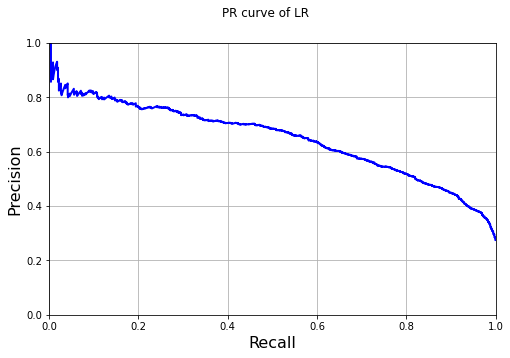

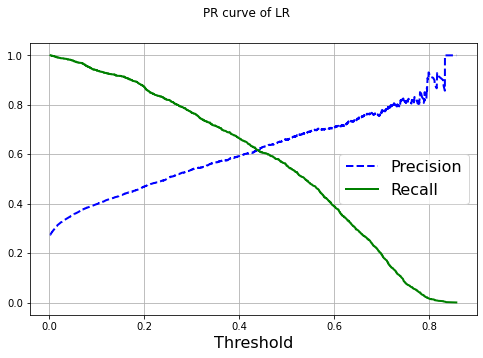

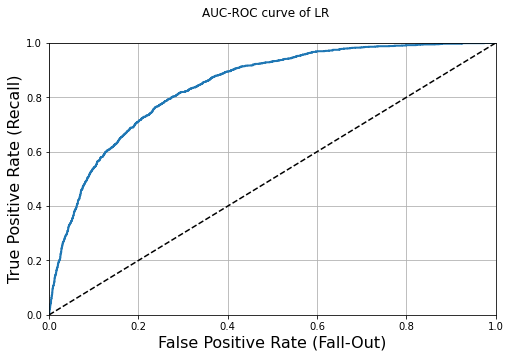

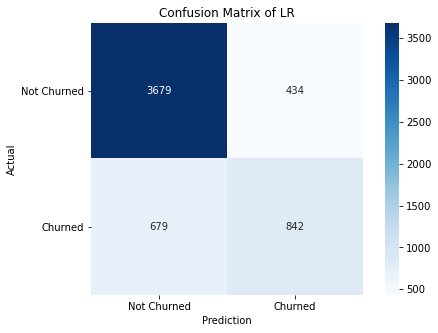

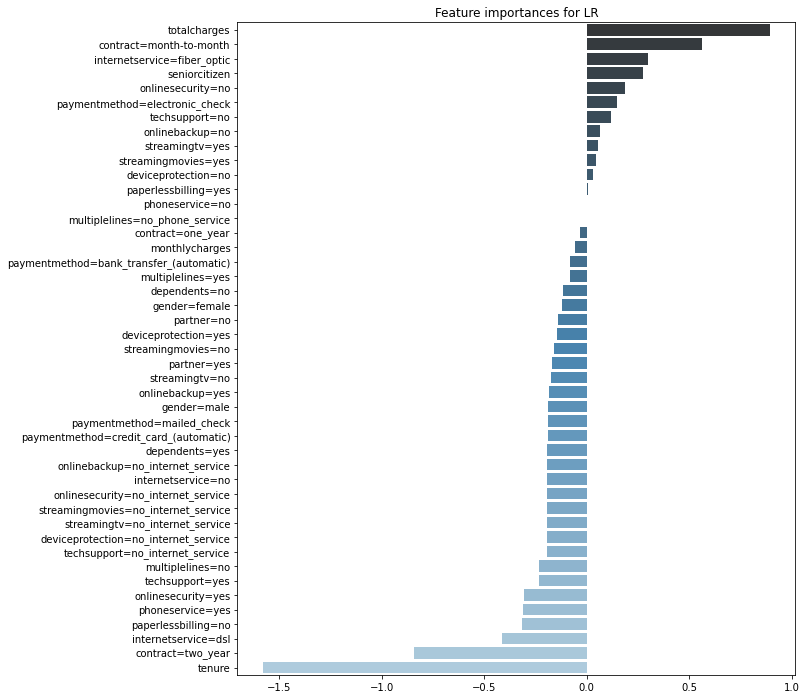

In [7]:
lr_model = LogisticRegression(solver='liblinear', random_state= 42)
lr_model_name = 'LR'
cv = 10
options = defaultdict(bool)
options['feature_importance_available'] =  True
options['coefficients'] = True

model_summary(lr_model_name, lr_model, X_train_full_scaled, y_train_full, X_train_scaled, 
                  y_train, X_val_scaled, y_val, cv, feature_names, evaluation_metrics, phase_one_metrics_collector_map, 
              options = options)


### Decision Tree

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      4113
           1       0.68      0.39      0.50      1521

    accuracy                           0.79      5634
   macro avg       0.74      0.66      0.68      5634
weighted avg       0.77      0.79      0.77      5634



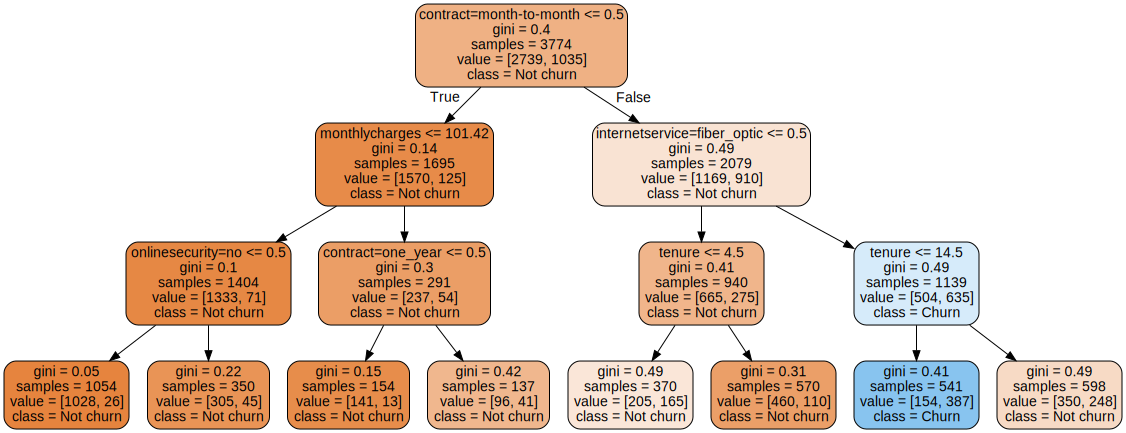

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR,0.582117,0.601705,0.841965,0.553569,0.660453,0.802454
1,DT,0.449512,0.495489,0.813864,0.391847,0.680234,0.786120


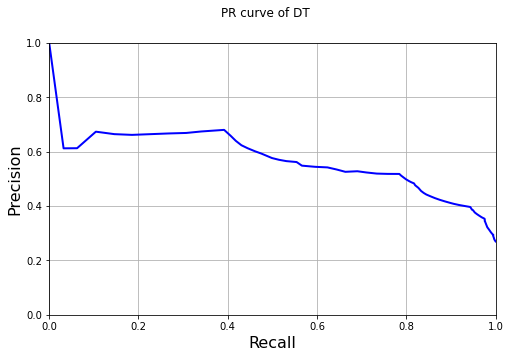

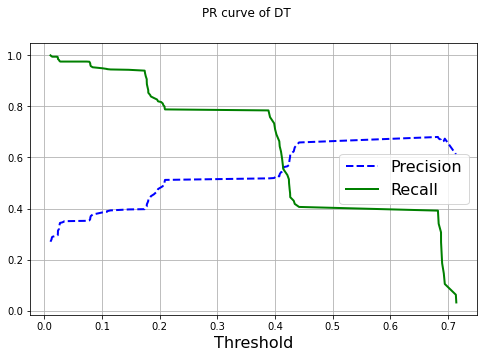

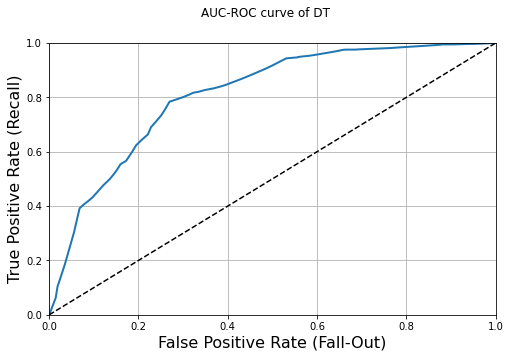

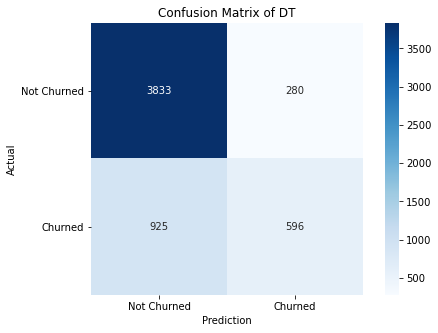

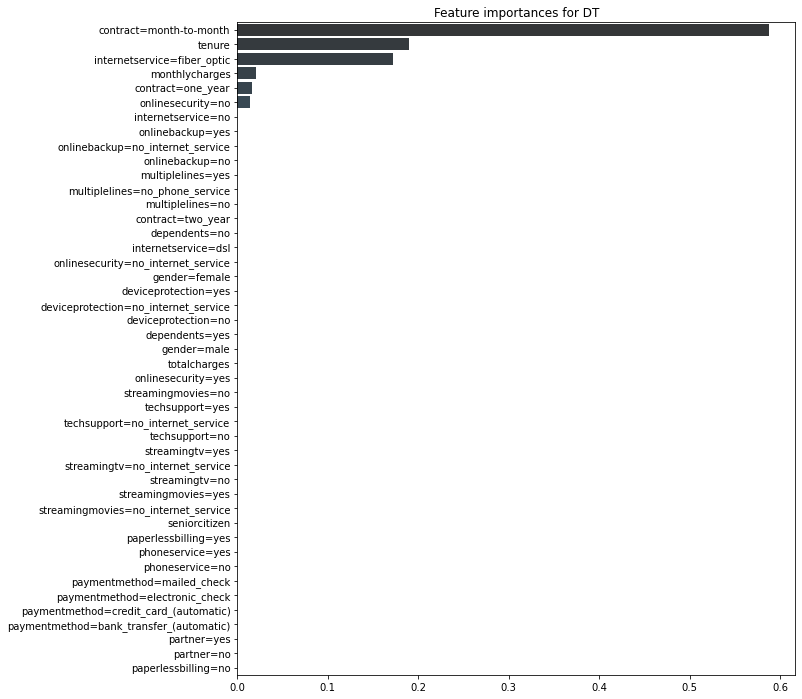

In [8]:
# DT
dt_classifier = DecisionTreeClassifier(random_state= 7, max_depth = 3)
dt_classifier_name = 'DT'
cv = 10
options = defaultdict(bool)
options['feature_importance_available'] =  True
options['tree_based'] = True

model_summary(dt_classifier_name, dt_classifier, X_train_full_not_scaled, y_train_full, X_train_not_scaled, 
                  y_train, X_val_not_scaled, y_val, cv, feature_names, evaluation_metrics, phase_one_metrics_collector_map,
              options = options)

### Random Forest

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      4113
           1       0.68      0.45      0.54      1521

    accuracy                           0.79      5634
   macro avg       0.75      0.68      0.70      5634
weighted avg       0.78      0.79      0.78      5634



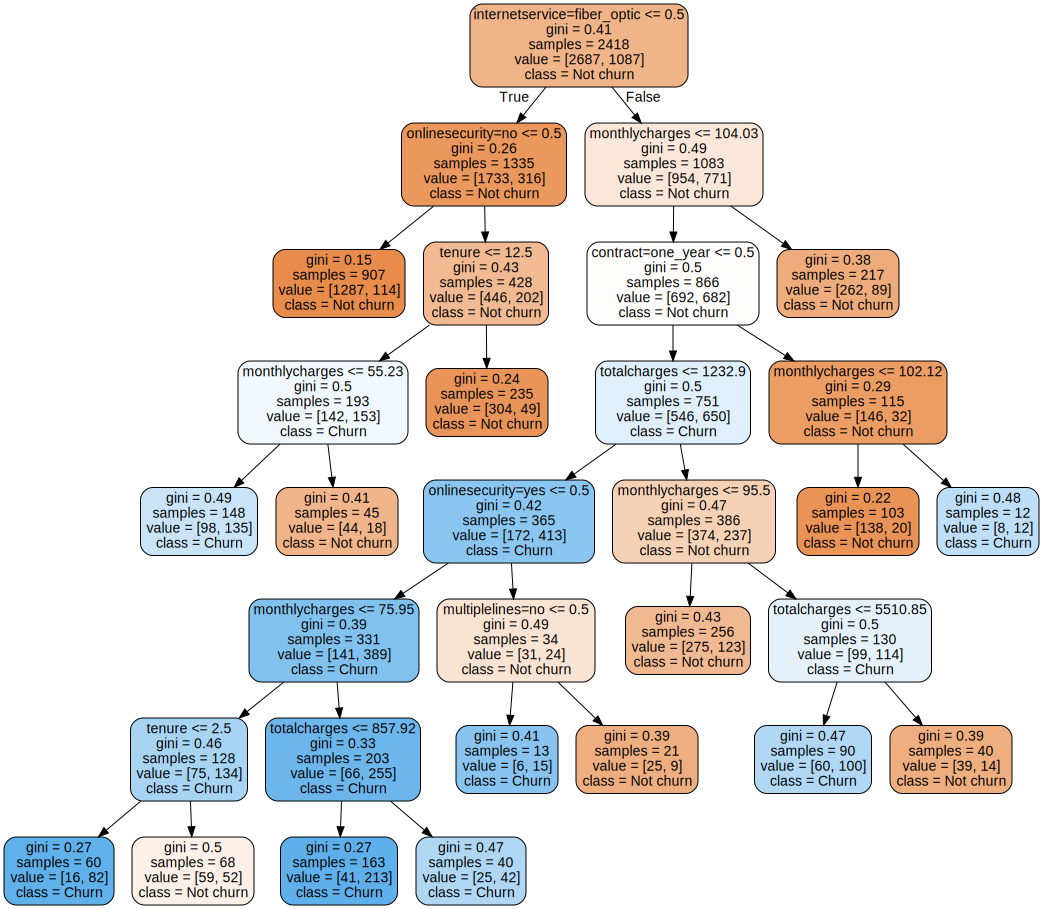

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR,0.582117,0.601705,0.841965,0.553569,0.660453,0.802454
1,DT,0.449512,0.495489,0.813864,0.391847,0.680234,0.786120
2,RF,0.497648,0.537176,0.840648,0.445756,0.680625,0.793930


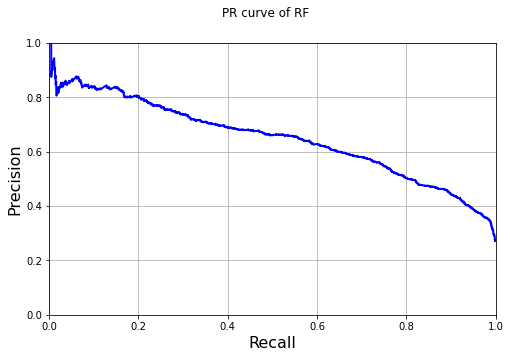

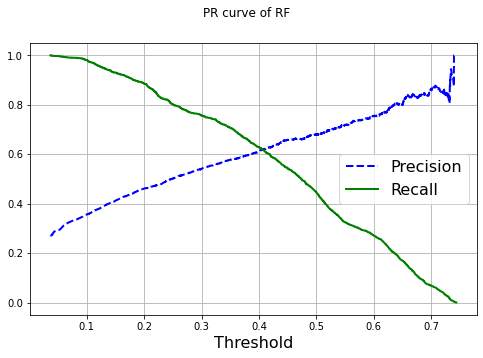

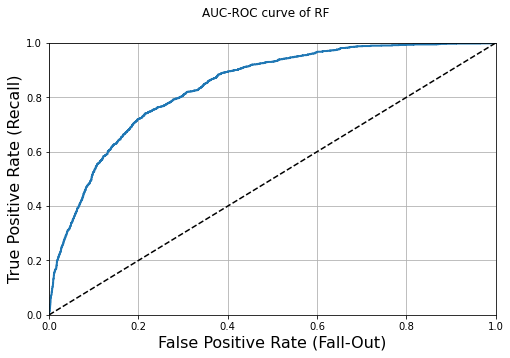

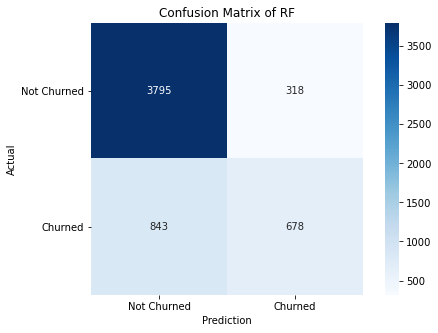

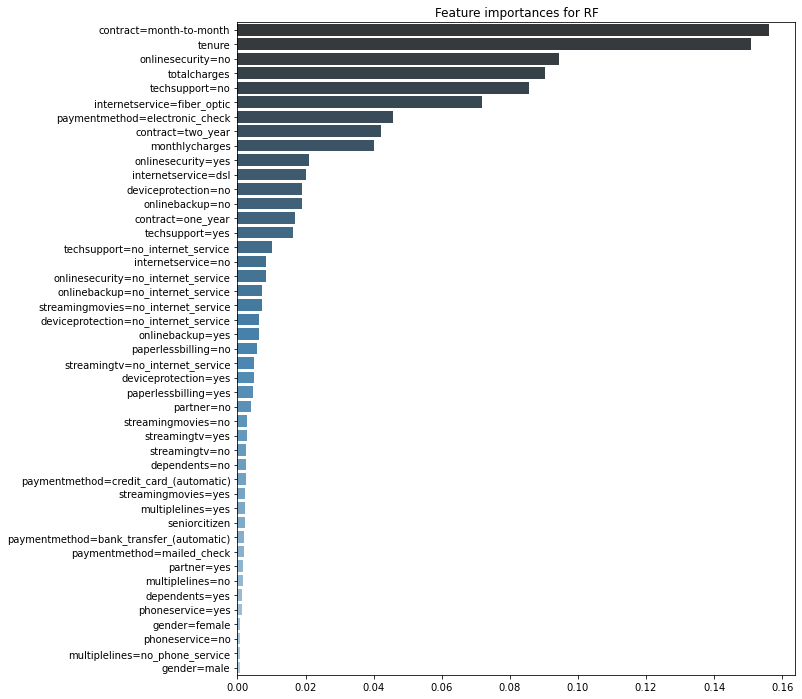

In [9]:
# Random Forest
random_forest_model = RandomForestClassifier(n_estimators=200, max_leaf_nodes=16, n_jobs=-1, random_state=7)
random_forest_model_name = 'RF'
cv = 10

options = defaultdict(bool)
options['feature_importance_available'] =  True
options['tree_based'] = True
options['estimated_tree'] = 190

model_summary(random_forest_model_name, random_forest_model, X_train_full_not_scaled, y_train_full, X_train_not_scaled, 
                  y_train, X_val_not_scaled, y_val, cv, feature_names, evaluation_metrics, phase_one_metrics_collector_map,
              options = options)

### KNN

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      4113
           1       0.57      0.53      0.55      1521

    accuracy                           0.77      5634
   macro avg       0.70      0.69      0.70      5634
weighted avg       0.76      0.77      0.76      5634



,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR,0.582117,0.601705,0.841965,0.553569,0.660453,0.802454
1,DT,0.449512,0.495489,0.813864,0.391847,0.680234,0.786120
2,RF,0.497648,0.537176,0.840648,0.445756,0.680625,0.793930
3,KNN,0.541260,0.549162,0.779625,0.529253,0.571309,0.765529


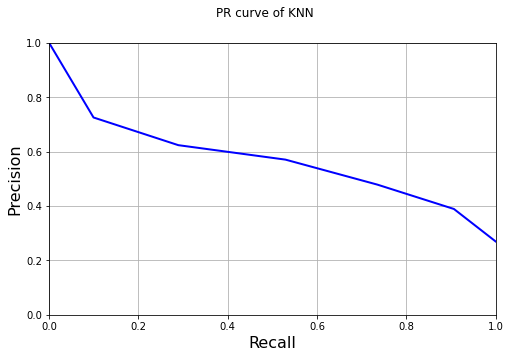

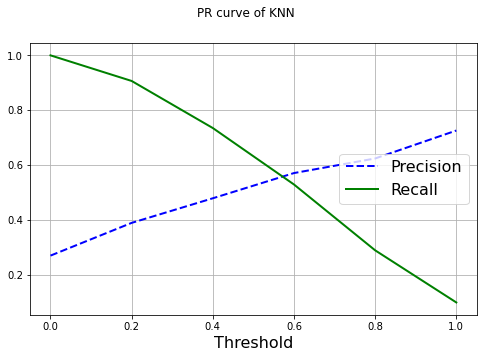

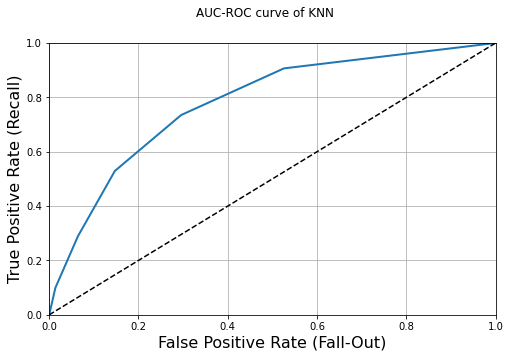

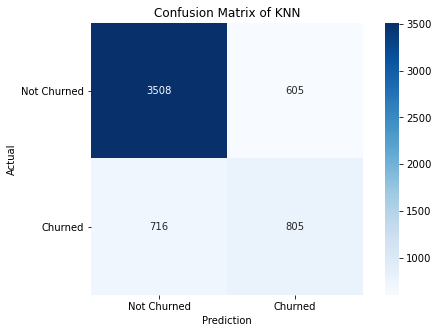

In [10]:
# KNN
knn_classifier = KNeighborsClassifier()
knn_classifier_model_name = 'KNN'
cv = 10
options = defaultdict(bool)

model_summary(knn_classifier_model_name, knn_classifier, X_train_full_scaled, 
              y_train_full, 
              X_train_scaled, 
              y_train, X_val_scaled, y_val, cv, feature_names, evaluation_metrics, phase_one_metrics_collector_map,
              options = options)


### SVC Bagging

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      4113
           1       0.67      0.49      0.56      1521

    accuracy                           0.80      5634
   macro avg       0.75      0.70      0.72      5634
weighted avg       0.79      0.80      0.79      5634



,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR,0.582117,0.601705,0.841965,0.553569,0.660453,0.802454
1,DT,0.449512,0.495489,0.813864,0.391847,0.680234,0.786120
2,RF,0.497648,0.537176,0.840648,0.445756,0.680625,0.793930
3,KNN,0.541260,0.549162,0.779625,0.529253,0.571309,0.765529
4,B_SVC,0.572627,0.589990,0.831084,0.556849,0.654509,0.799608


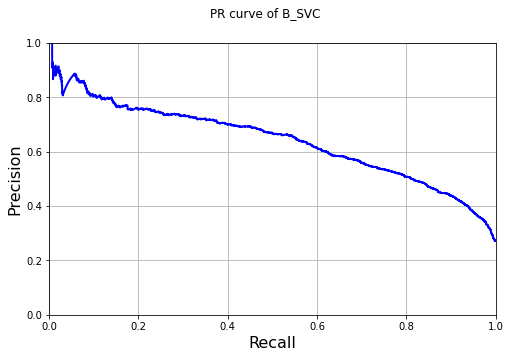

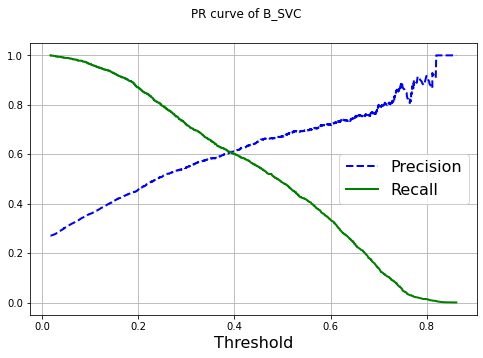

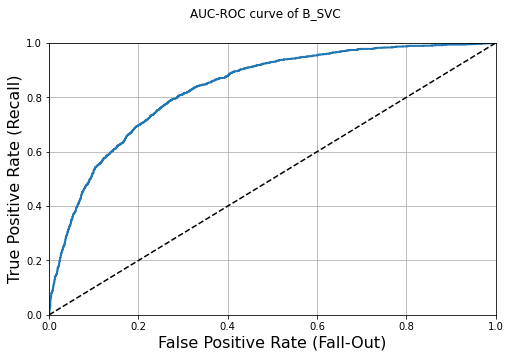

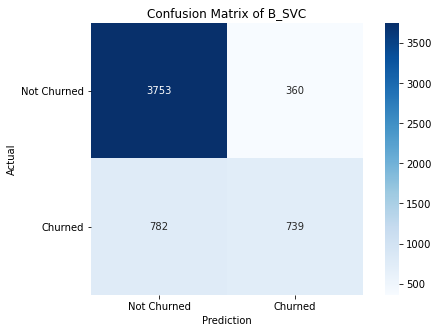

In [11]:
# SVC Bagging : https://stackoverflow.com/questions/31681373/making-svm-run-faster-in-python
"""
To speed up the training time with SVC,  we can use ensembles of SVCs that are trained on subsets of the data 
to reduce the number of records per classifier (which apparently has quadratic influence on complexity).
"""
n_estimators = 5
svc_bagging_model = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True, random_state= 7), max_samples=1.0 / n_estimators, n_estimators=n_estimators))
svc_bagging_model_name = 'B_SVC'
cv = 5
options = defaultdict(bool)
model_summary(svc_bagging_model_name, svc_bagging_model, X_train_full_scaled, 
              y_train_full, 
              X_train_scaled, 
              y_train, X_val_scaled, y_val, cv, feature_names, evaluation_metrics, phase_one_metrics_collector_map,
              options = options)

### Gaussian Naive Bayes

              precision    recall  f1-score   support

           0       0.91      0.63      0.75      4113
           1       0.46      0.84      0.59      1521

    accuracy                           0.69      5634
   macro avg       0.69      0.74      0.67      5634
weighted avg       0.79      0.69      0.71      5634



,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR,0.582117,0.601705,0.841965,0.553569,0.660453,0.802454
1,DT,0.449512,0.495489,0.813864,0.391847,0.680234,0.786120
2,RF,0.497648,0.537176,0.840648,0.445756,0.680625,0.793930
3,KNN,0.541260,0.549162,0.779625,0.529253,0.571309,0.765529
4,B_SVC,0.572627,0.589990,0.831084,0.556849,0.654509,0.799608
5,GNB,0.667782,0.592313,0.813847,0.838949,0.457860,0.688140


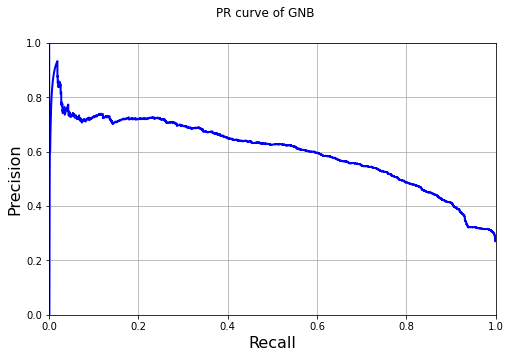

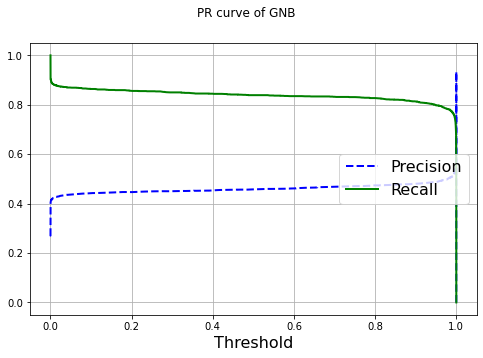

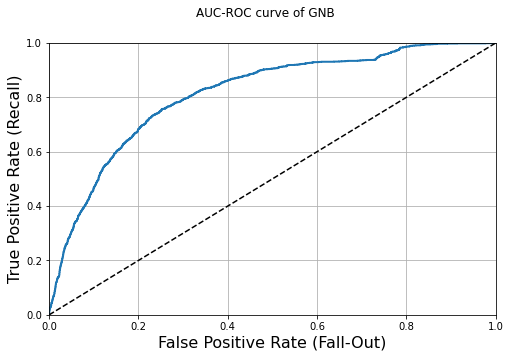

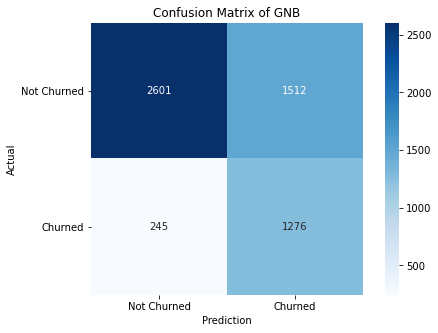

In [12]:
gnb_model = GaussianNB()
gnb_model_name = 'GNB'
cv = 10
options = defaultdict(bool)

model_summary(gnb_model_name, gnb_model, X_train_full_not_scaled, 
              y_train_full, 
              X_train_not_scaled, 
              y_train, X_val_not_scaled, y_val, cv, feature_names, evaluation_metrics, phase_one_metrics_collector_map,
              options = options)

### Latent Dirichlet allocation

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      4113
           1       0.64      0.55      0.59      1521

    accuracy                           0.79      5634
   macro avg       0.74      0.72      0.73      5634
weighted avg       0.79      0.79      0.79      5634



,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR,0.582117,0.601705,0.841965,0.553569,0.660453,0.802454
1,DT,0.449512,0.495489,0.813864,0.391847,0.680234,0.786120
2,RF,0.497648,0.537176,0.840648,0.445756,0.680625,0.793930
3,KNN,0.541260,0.549162,0.779625,0.529253,0.571309,0.765529
4,B_SVC,0.572627,0.589990,0.831084,0.556849,0.654509,0.799608
5,GNB,0.667782,0.592313,0.813847,0.838949,0.457860,0.688140
6,LDA,0.572806,0.589451,0.833326,0.548314,0.638680,0.793933


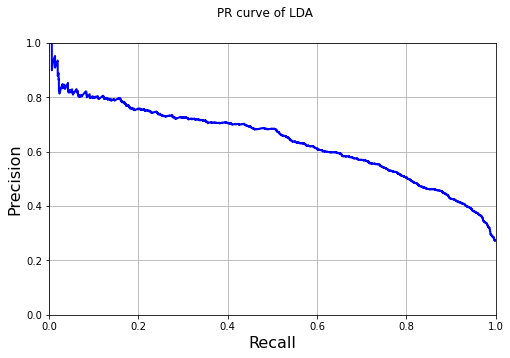

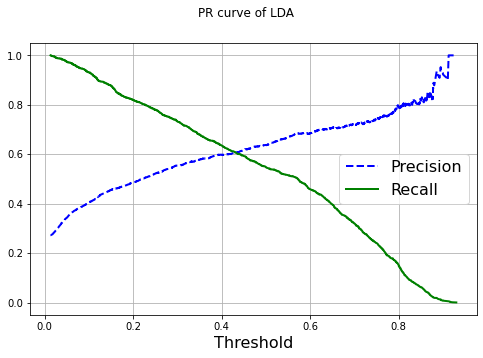

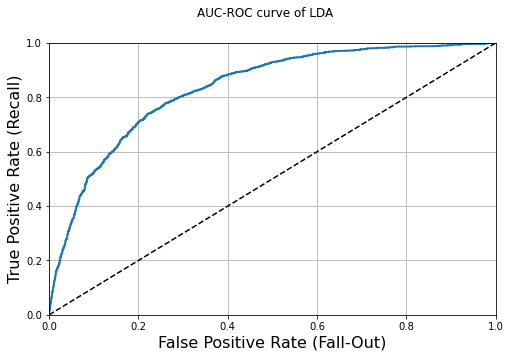

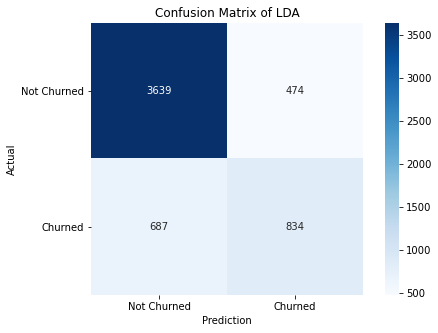

In [13]:
lda_model = LinearDiscriminantAnalysis()
lda_model_name = 'LDA'
cv = 10

options = defaultdict(bool)

model_summary(lda_model_name, lda_model, X_train_full_not_scaled, 
              y_train_full, 
              X_train_not_scaled, 
              y_train, X_val_not_scaled, y_val, cv, feature_names, evaluation_metrics, 
              phase_one_metrics_collector_map,
              options = options)

### Evaluation Metric Analysis

In [14]:
# Store all evaluation metrics in a dataframe
phase_one_model_to_evaluation_metrics_df = pd.DataFrame(phase_one_metrics_collector_map)

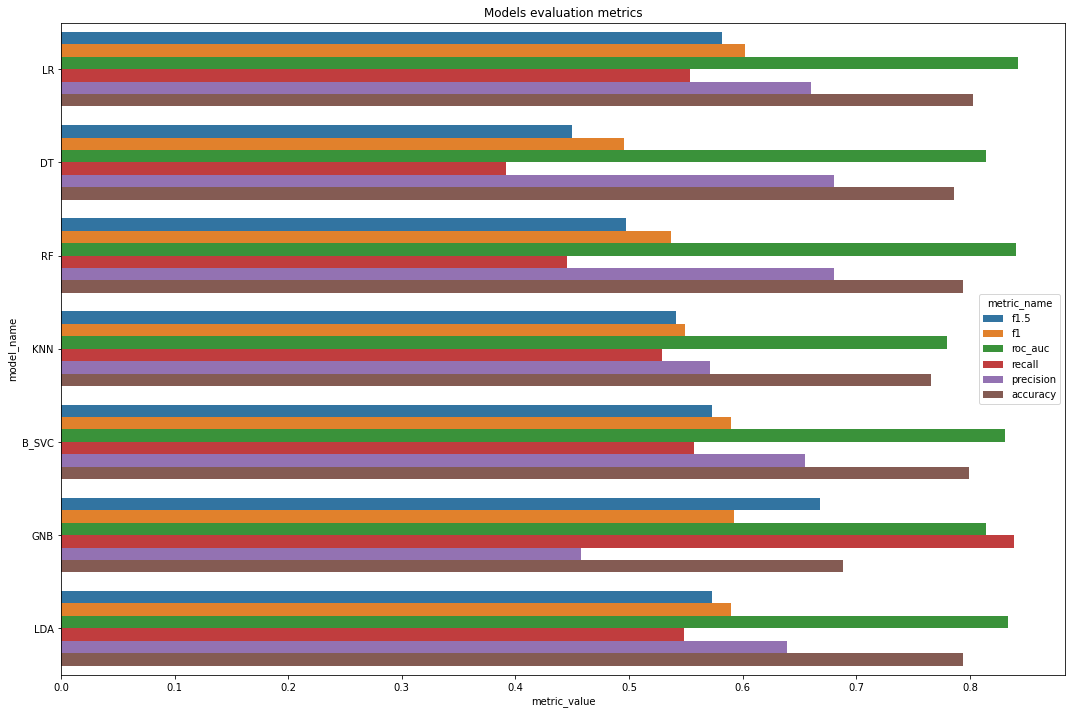

In [15]:
# Plotting all evaluation metrics and all models together
model_with_evaluation_metrics_names_and_values = {
    'model_name' : [],
    'metric_name' : [],
    'metric_value' : []
}

for row_hash in phase_one_model_to_evaluation_metrics_df.to_dict(orient='records'):
    for metric in evaluation_metrics:
        model_with_evaluation_metrics_names_and_values['metric_name'].append(metric)
        model_with_evaluation_metrics_names_and_values['metric_value'].append(row_hash[metric])
        model_with_evaluation_metrics_names_and_values['model_name'].append(row_hash['model_name'])

model_with_evaluation_metrics_names_and_values_df = pd.DataFrame(model_with_evaluation_metrics_names_and_values)
fig, axis = plt.subplots(1, 1, figsize=(18,12))
axis.set_title("Models evaluation metrics")
axis_y = "metric_value"

ax = sns.barplot(x=axis_y, y='model_name' , hue='metric_name', 
                 data=model_with_evaluation_metrics_names_and_values_df, 
                 ax=axis)


In [16]:
# Sorting evaluation metrics by f1.5
phase_one_model_to_evaluation_metrics_df_by_f1_point_5 = phase_one_model_to_evaluation_metrics_df.sort_values(by=['f1.5'],ascending=False)
phase_one_model_to_evaluation_metrics_df_by_f1_point_5

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
5,GNB,0.667782,0.592313,0.813847,0.838949,0.457860,0.688140
0,LR,0.582117,0.601705,0.841965,0.553569,0.660453,0.802454
6,LDA,0.572806,0.589451,0.833326,0.548314,0.638680,0.793933
4,B_SVC,0.572627,0.589990,0.831084,0.556849,0.654509,0.799608
3,KNN,0.541260,0.549162,0.779625,0.529253,0.571309,0.765529
2,RF,0.497648,0.537176,0.840648,0.445756,0.680625,0.793930
1,DT,0.449512,0.495489,0.813864,0.391847,0.680234,0.786120


In [17]:
# Sorting evaluation metrics by f1
phase_one_model_to_evaluation_metrics_df_by_f1 = phase_one_model_to_evaluation_metrics_df.sort_values(by=['f1'],ascending=False)
phase_one_model_to_evaluation_metrics_df_by_f1

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR,0.582117,0.601705,0.841965,0.553569,0.660453,0.802454
5,GNB,0.667782,0.592313,0.813847,0.838949,0.457860,0.688140
4,B_SVC,0.572627,0.589990,0.831084,0.556849,0.654509,0.799608
6,LDA,0.572806,0.589451,0.833326,0.548314,0.638680,0.793933
3,KNN,0.541260,0.549162,0.779625,0.529253,0.571309,0.765529
2,RF,0.497648,0.537176,0.840648,0.445756,0.680625,0.793930
1,DT,0.449512,0.495489,0.813864,0.391847,0.680234,0.786120


In [18]:
# Sorting evaluation metrics by roc-auc
phase_one_model_to_evaluation_metrics_df_by_roc_auc = phase_one_model_to_evaluation_metrics_df.sort_values(by=['roc_auc'],ascending=False)
phase_one_model_to_evaluation_metrics_df_by_roc_auc


,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR,0.582117,0.601705,0.841965,0.553569,0.660453,0.802454
2,RF,0.497648,0.537176,0.840648,0.445756,0.680625,0.793930
6,LDA,0.572806,0.589451,0.833326,0.548314,0.638680,0.793933
4,B_SVC,0.572627,0.589990,0.831084,0.556849,0.654509,0.799608
1,DT,0.449512,0.495489,0.813864,0.391847,0.680234,0.786120
5,GNB,0.667782,0.592313,0.813847,0.838949,0.457860,0.688140
3,KNN,0.541260,0.549162,0.779625,0.529253,0.571309,0.765529


In [19]:
# Sorting evaluation metrics by precision
phase_one_model_to_evaluation_metrics_df_by_precision = phase_one_model_to_evaluation_metrics_df.sort_values(by=['precision'],ascending=False)
phase_one_model_to_evaluation_metrics_df_by_precision

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
2,RF,0.497648,0.537176,0.840648,0.445756,0.680625,0.793930
1,DT,0.449512,0.495489,0.813864,0.391847,0.680234,0.786120
0,LR,0.582117,0.601705,0.841965,0.553569,0.660453,0.802454
4,B_SVC,0.572627,0.589990,0.831084,0.556849,0.654509,0.799608
6,LDA,0.572806,0.589451,0.833326,0.548314,0.638680,0.793933
3,KNN,0.541260,0.549162,0.779625,0.529253,0.571309,0.765529
5,GNB,0.667782,0.592313,0.813847,0.838949,0.457860,0.688140


In [20]:
# Sorting evaluation metrics by recall
phase_one_model_to_evaluation_metrics_df_by_recall = phase_one_model_to_evaluation_metrics_df.sort_values(by=['recall'],ascending=False)
phase_one_model_to_evaluation_metrics_df_by_recall

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
5,GNB,0.667782,0.592313,0.813847,0.838949,0.457860,0.688140
4,B_SVC,0.572627,0.589990,0.831084,0.556849,0.654509,0.799608
0,LR,0.582117,0.601705,0.841965,0.553569,0.660453,0.802454
6,LDA,0.572806,0.589451,0.833326,0.548314,0.638680,0.793933
3,KNN,0.541260,0.549162,0.779625,0.529253,0.571309,0.765529
2,RF,0.497648,0.537176,0.840648,0.445756,0.680625,0.793930
1,DT,0.449512,0.495489,0.813864,0.391847,0.680234,0.786120


In [21]:
# Sorting evaluation metrics by accuracy
phase_one_model_to_evaluation_metrics_df_by_accuracy = phase_one_model_to_evaluation_metrics_df.sort_values(by=['accuracy'],ascending=False)
phase_one_model_to_evaluation_metrics_df_by_accuracy

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR,0.582117,0.601705,0.841965,0.553569,0.660453,0.802454
4,B_SVC,0.572627,0.589990,0.831084,0.556849,0.654509,0.799608
6,LDA,0.572806,0.589451,0.833326,0.548314,0.638680,0.793933
2,RF,0.497648,0.537176,0.840648,0.445756,0.680625,0.793930
1,DT,0.449512,0.495489,0.813864,0.391847,0.680234,0.786120
3,KNN,0.541260,0.549162,0.779625,0.529253,0.571309,0.765529
5,GNB,0.667782,0.592313,0.813847,0.838949,0.457860,0.688140


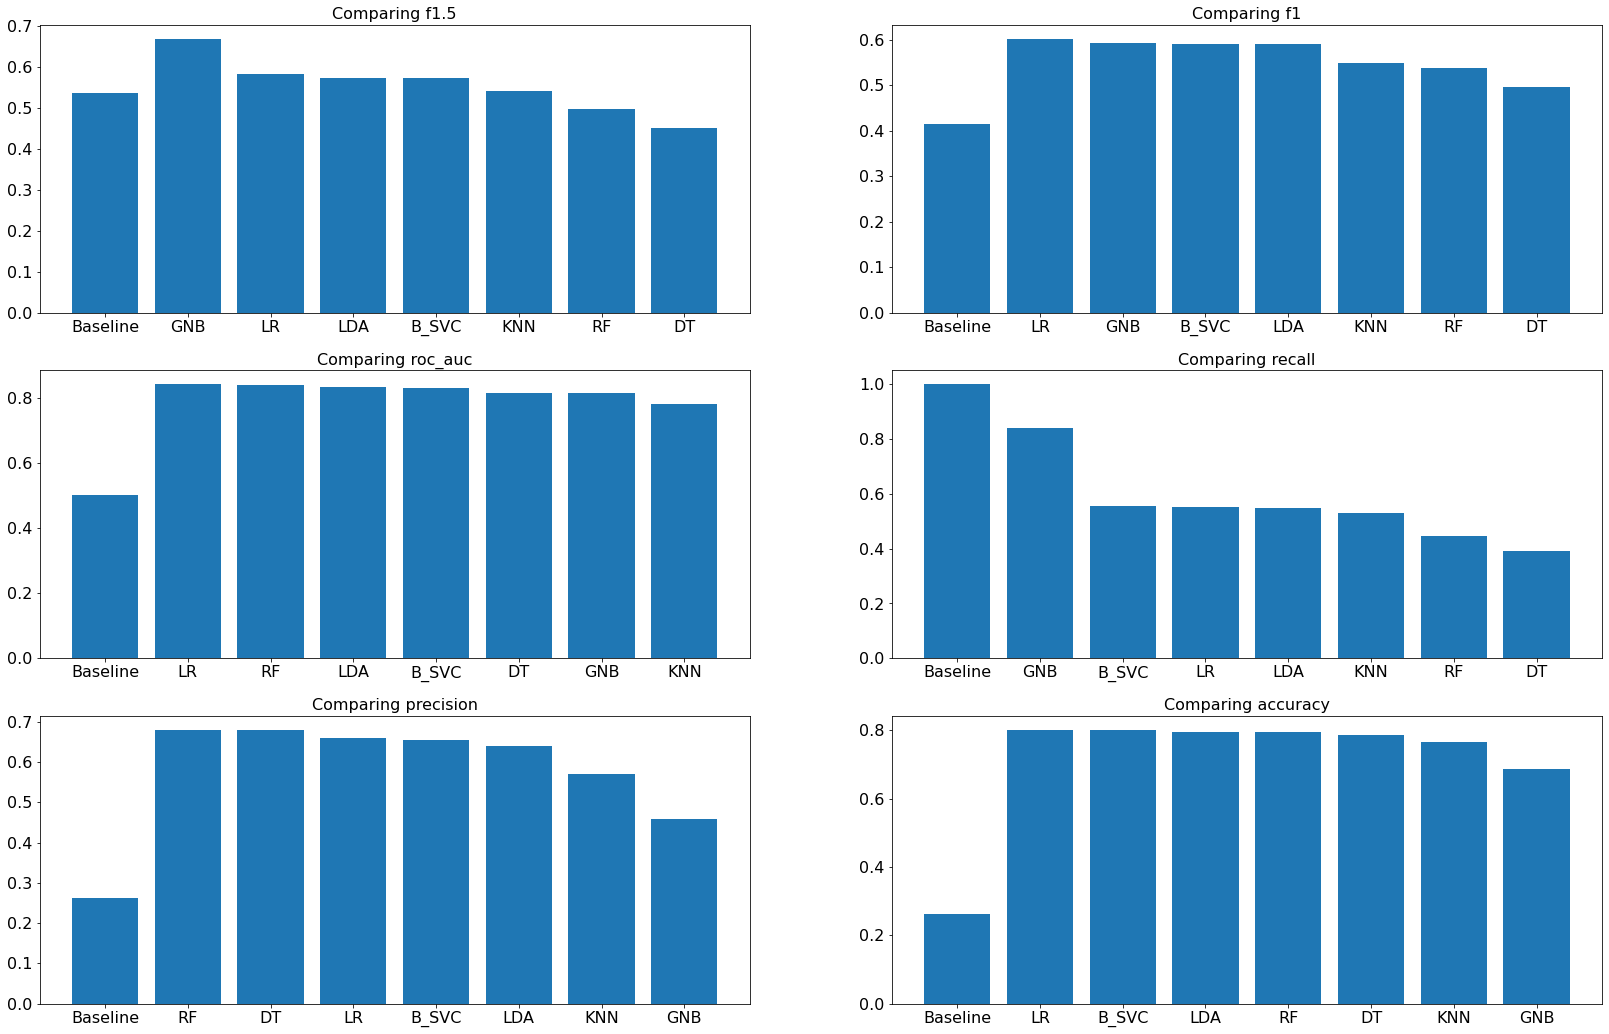

In [22]:
nrows = 3
ncols = 2
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(28,18))
for r in range(nrows):
    for c in range(ncols):
        subplot_ax = ax[r][c]
        if r == 0:
            index = c
        else:
            index = int(math.pow(2, r) + c)
        metric = evaluation_metrics[index]
        model_names = ['Baseline'] + list(phase_one_model_to_evaluation_metrics_df.sort_values(by=[metric], ascending=False)['model_name'])
        metric_scores = list(baseline_performance_on_training_data_map[metric]) + list(phase_one_model_to_evaluation_metrics_df.sort_values(by=[metric], ascending=False)[metric])
        subplot_ax.bar(model_names, metric_scores)
        subplot_ax.set_xticklabels(model_names, fontsize=16)
        subplot_ax.tick_params(axis="y", labelsize=16) 
        subplot_ax.set_title('Comparing {}'.format(metric), fontsize=16)

In [25]:
%store phase_one_model_to_evaluation_metrics_df
%store baseline_performance_metrics_df
%store phase_one_metrics_collector_map

Stored 'phase_one_model_to_evaluation_metrics_df' (DataFrame)
Stored 'baseline_performance_metrics_df' (DataFrame)
Stored 'phase_one_metrics_collector_map' (defaultdict)
